<a href="https://colab.research.google.com/github/BankNatchapol/Quantum-Tutorial/blob/main/QAOA_Maxcut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit
!pip install pylatexenc

     |████████████████████████████████| 6.1 MB 8.4 MB/s 
     |████████████████████████████████| 18.0 MB 270 kB/s 
     |████████████████████████████████| 234 kB 57.6 MB/s 
     |████████████████████████████████| 207 kB 58.5 MB/s 
     |████████████████████████████████| 2.1 MB 31.4 MB/s 
     |████████████████████████████████| 199 kB 57.8 MB/s 
     |████████████████████████████████| 1.4 MB 31.6 MB/s 
     |████████████████████████████████| 635 kB 47.0 MB/s 
     |████████████████████████████████| 68 kB 6.6 MB/s 
     |████████████████████████████████| 33.9 MB 45 kB/s 
     |████████████████████████████████| 943 kB 37.0 MB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 3.2 MB 34.5 MB/s 
     |████████████████████████████████| 6.3 MB 30.6 MB/s 
  Created wheel for qiskit: filename=qiskit-0.28.0-py3-none-any.whl size=11090 sha256=7b0c376f1f70ec80f1dad6f5606803ee20a20f731d587417f86d1e065d9bbc73
  Stored in directory: /root/.cache/pip/whe

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

from qiskit.visualization import plot_histogram

# **Define graph**

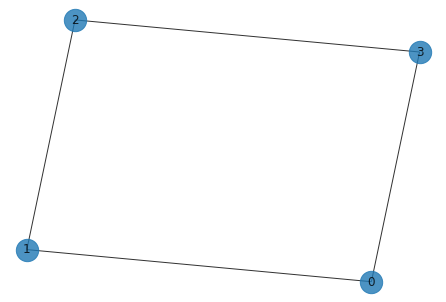

In [ ]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

In [ ]:
# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()
adjacency

matrix([[0, 1, 0, 1],
        [1, 0, 1, 0],
        [0, 1, 0, 1],
        [1, 0, 1, 0]], dtype=int64)

# **Define QAOA**

## Pauli-X mixer Hamiltonian

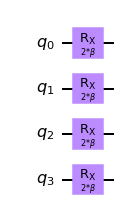

In [ ]:
nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw("mpl")

## Problem Hamiltonian

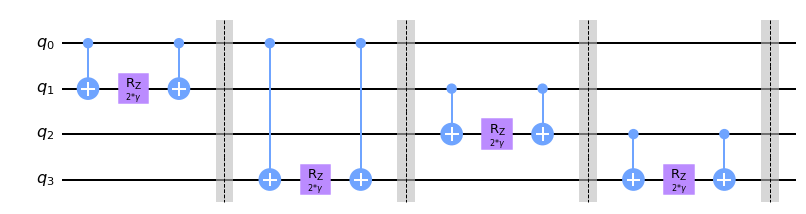

In [ ]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw("mpl")

## Initial superposition of all qubits

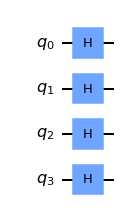

In [ ]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw("mpl")

## Combine all circuit together

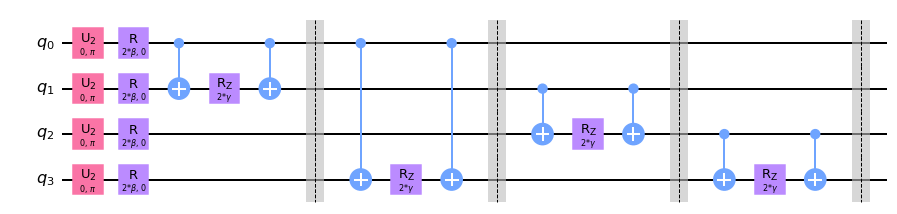

In [ ]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw("mpl")

# **Compute Expectation**

## MaxCut Objective function
$$\underset{s}{max}\frac{1}{2}\sum_{ij\in E}(1-s_{i}s_{j})  \quad\quad s_{i} \in \begin{Bmatrix}
 -1&,+1 
\end{Bmatrix}$$
given each node value with -1, +1 to maximize objective function

In [ ]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

# **Optimization**

In [ ]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=2)

res = minimize(expectation, 
                      [1.0, 1.0 ,1.0, 1.0], 
                      method='COBYLA')
res

     fun: -3.92578125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 40
  status: 1
 success: True
       x: array([2.08522423, 2.1753362 , 1.00239937, 1.056763  ])

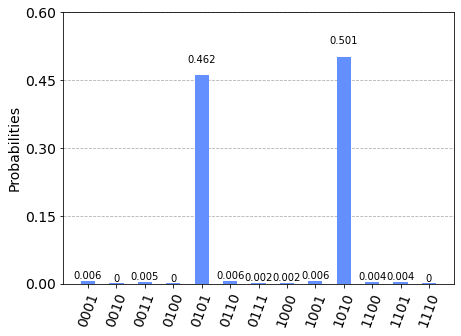

In [ ]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

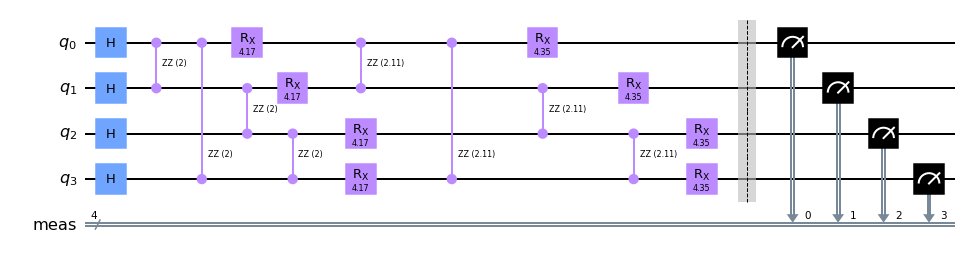

In [ ]:
qc_res.draw("mpl")